# Example 1.5.4
This is a set of examples where we implement a multilayer perceptron

In [1]:
import matplotlib.pyplot as plt
import numpy as np


## Data
We first define a function that generates toy datasets. Our datasets are the xor problem and the circle problem. We define them here and some plots to illustrate them are below.

In [2]:
#Data. Here we add several data examples, including the "circle" and the "xor" problems.
import numpy as np
def data(name):
    if name=='xor' :
        N=100 #Number of data per cluster
        sigma=0.6 # standard deviation of the clusters
        classes=[0,1,1,0]
        X=sigma*np.random.randn(2,4*N) # Generate 4*N random vectors (gaussian) centered around zero
        mean=np.array([[-1,-1, 1, 1],[-1,1,-1,1]]) # define four means
        M=np.ones((N,2))*mean[:,0] # Means of the first cluster
        y=np.ones((1,N))*classes[0] # Labels of the first cluster
        for i in range(1,4):
            m=np.ones((N,2))*mean[:,i] # Means of cluster i
            M=np.concatenate((M,m))     #Concatenate all means
            y=np.concatenate((y,np.ones((1,N))*classes[i]),axis=1) # concatenate labels
        M=M.T
        X=X+M # Add means to the data.

    elif name=='circle':
        N=250;
        sigma=0.05
        theta=np.random.rand(1,N)*np.pi*2
        rho=np.random.randn(1,N)*sigma+1
        X1=rho*np.block([[np.cos(theta)],[np.sin(theta)]]) #circular data corresponding to class 1

        theta=np.random.rand(1,N)*2*np.pi
        rho=np.random.randn(1,N)*sigma+0.8
        X2=rho*np.block([[np.cos(theta)],[np.sin(theta)]])

        y=np.concatenate((0*np.ones((1,N)),np.ones((1,N))),axis=1) # labels
        X=np.concatenate((X1,X2),axis=1)

    return X,y


Here we just print the dataset. Later, we will print the dataset together with the results of the classification.

## Structure: Activations and neural network topology
It includes the definition of the structured variable containing all NN parameters, the forward pass and the backward pass. In this first chapter we will use juast functions but no classes, to make the coding. the easiest possible. In Chapter 2 we will reproduce a version of this code with the use of classes and other Python feaurter that actually make coding more efficient and easy.

We also define some activation functions, which are tested below.

This assumes that the input data is a vector, but we will see later how to generalize this to a more general input array, which will need tensors of weights. The final implementation of the neural network will be a lot more general, and this example is just an introductory one to illustrate how a simple neural network works.

### Activations

We define here the logistic, linear and rectified linear (ReLU) activations. They are:

$$
    \phi(z) = \frac{1}{1+\exp(-z)}, \text{ Logistic}
$$

$$
\phi(z) = z, \text{ Linear}
$$

$$
\phi(z) = \max(0,z), \text{ ReLU}
$$

The last one is only used for the hidden units, and the other two also for the output

In [3]:
# Di,Do:        Number of inputs and outputs

def sigma(z,activation):
    # activations: 'ReLU', 'logistic'. maxOut and SoftMax left as an exercise for the reader.
    if activation=="logistic":
        h=1/(1+np.exp(-z))
        dh=h*(1-h)
    elif activation=="linear":
        h=z
        dh=np.ones((1,z.size))
    elif activation=="relu":
        h=np.maximum(0,z)
        dh=np.maximum(0,z>0)
    elif activation=="maxout":
        pass
    elif activation=="softmax":
        pass
    return h,dh



### Topology of the neural network

Here we define a layer with weights initialized following the _Xavier_ method, and then we define a neural network with arbitrary layers and nodes inside a dictionary called NN

In [4]:
def layer(Di,Do,activation):
    # Create some structures for the weights and the biases
    # Here we assume that the input is a vector, so the weights are a 2D array
    W=np.random.randn(Di,Do)/np.sqrt(Di) #This is simply the Xavier initialization
    b=np.random.randn(1,Do)/np.sqrt(Di)
    return W,b,activation

def neural_network(D,activations,output):
    # Puts the neural network as a dictionary
    # D: np. array with the number of nodes in each layer, including input and output
    # activations: Hidden node activations--'ReLU', 'logistic', 'maxOut' (not implemented yet)
    # output: Output layer activations--'linear', 'logistic', 'softMax (not implemented yet)
    NN={"weights":[],"bias":[],"activation":[]}
    for i in range(D.size-1):
        W,b,activation =  layer(D[i],D[i+1],activations)
        NN["weights"].append(W)
        NN["bias"].append(b)
        NN["dimensions"]=D
        if i<D.size-2:
            NN["activation"].append(activation)
        else:
            NN["activation"].append(output)
    return NN

## Training criterion and algorithm

### Forward pass

Here we construct the fordward pass, where the input is a set of data, and it serves either as the forward pass of the training or as the output of a test data.

In [5]:
#

def forward(NN,X):
    #Computes all the outputs and derivatives for all the layers of the neural network
    N=X.shape[-1]     # We assume that the number of samples is contained in the last dimension of them
    aux={"N":N,"h":[],"dh":[],"z":[]}
    D=NN["dimensions"]
    # Create zero arrays for the outputs
    for i in range(D.size-1):
        aux["h"].append(np.zeros((NN["weights"][i].shape[1],N)))
        aux["dh"].append(np.zeros(( NN["weights"][i].shape[1],N)))
        aux["z"].append(np.zeros(( NN["weights"][i].shape[1],N)))
    NN.update(aux)

    # Forward pass
    NN["z"][0]=NN["weights"][0].T@X+NN["bias"][0].T
    NN["h"][0],NN["dh"][0]=sigma(NN["z"][0],NN["activation"][0])

    for i in range(D.size-2):
        NN["z"][i+1]=NN["weights"][i+1].T@NN["h"][i]+NN["bias"][i+1].T
        NN["h"][i+1],NN["dh"][i+1]=sigma(NN["z"][i+1],NN["activation"][i+1])
    return NN
    # See if this can be done in one step.




### Backward pass
This is the backpropagation, that needs to define the cost functions and their derivatives. In the backward pass, the loss gradients with respect to each parameter are computed for all training samples, added together for all samples and then the weights are updated. This is what is usually called an epoch.

#### Cost functions
For the case of logistic activation (corresponding to a Bernoulli likelihood), during the training $o(z)=p(y|{\bf x})=\frac{1}{1+e^{-(2y-1)z}} = \sigma((2y-1)z)$. Therefore

${o}' =\frac{do(z)}{dz}= {o}(1-{o})(1-2y)$

The cost function is the log likelihood

$
J_{ML}({\boldsymbol \theta},{\bf X},{\bf y})=\sum_{i=1}^N\left[ \log\left(1+e^{(1-2y_i)z_i}\right)\right]= \sum_{i=1}^N\log\left(o(z_i)\right)
$

Thus $\frac{d}{do}J_{ML}({o})=\frac{1}{o}$.

The error term of the last layer is

$
{\boldsymbol \delta}^{(L)} = \nabla_{o}J_{ML}({\bf y},{o}) \odot {o}'
$

Putting everything together, we have

$
{\boldsymbol \delta}^{(L)} = (1-{\bf o})(1-2y)
$

The equation is implemented in function _'backward'_, activation _'logistic'_.

In [6]:
def backward(NN,X,y,mu,gamma):
    # Exercise for the reader: compute the cost function output.
    D=NN["dimensions"]
    N=X.shape[-1]
    if NN["activation"][-1]=="linear":
        dJ=NN["h"][-1]-y
        #J=np.sum(dJ*dJ)
        delta = dJ*NN["dh"][-1]

    if NN["activation"][-1]=="logistic":
        o,do=sigma((2*y-1)*NN["z"][-1],"logistic")
        delta = (1-2*y)*(1-o)
        ### This is an implementation of the MMSE error, for comparisons
        #o,do=sigma(NN["z"][-1],"logistic")
        #delta=(o-y)*(1-o)*o

    if NN["activation"][-1]=="softmax":
        pass

    NN["weights"][-1]=(1-gamma)*NN["weights"][-1]-mu*NN["h"][-2]@delta.T/N
    NN["bias"][-1]=(1-gamma)*NN["bias"][-1]-mu*np.sum(delta)/N
    for i in range(D.size-2):
        j=-i-1 #This is to go backwards
        delta=NN["dh"][j]*delta
        NN["weights"][j]=(1-gamma)*NN["weights"][j]-mu*NN["h"][j-1]@delta.T/N
        NN["bias"][j]=(1-gamma)*NN["bias"][j]-mu*np.sum(delta)/N
        delta=NN['weights'][j]@delta
    return NN

def mse(NN,y):

    # This is the mean square error, for validation purposes
    # Exercise for the reador: compute the losss correspodning to each one of the activations and the
    # error rate.
    e=np.sum(np.square(NN["h"][-1]-y),1)/NN["N"]
    return e

## Data and neural network construction  
We plot the training data and declare the neural network structure and .

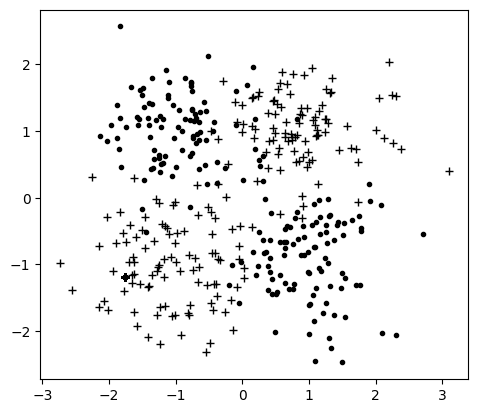

In [7]:
dataset='xor'                  # we have the 'xor' and the 'circle' datasets.
output_activation="logistic"   # Here we determine what activatios we want
hidden_activation="relu"
D=np.array([2,100,1]) #We define here the number of nodes per layer
np.random.seed(30)      # We use this seed so we can repear an experiment several times with the same data
X,y=data(dataset)       # Get the data
Xtst,ytst=data(dataset)

# Training Data plotting
indexn=np.where(y==0)
indexp=np.where(y==1)
plt.plot(X[0,indexp], X[1,indexp], 'k.')
plt.plot(X[0,indexn], X[1,indexn], 'k+')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Construct a neural network. The input has dimension 2 and the
# output has 1 dimension (for binary classification)

NN=neural_network(np.array(D),hidden_activation,output_activation)



## Neural network training and test
Here the number of epochs are

In [8]:
epochs=10000
E=np.zeros((epochs))
Etst=np.zeros((epochs))

#Train and test the neural network
for i in range(epochs):
    NN=forward(NN,X)                # This is the forward pass that computes z, h and dh for the training data.
    NN=backward(NN,X,y,0.5,0.00)    # This is the training
    E[i]=mse(NN,y)                 # Compute the training MMSE.

    NN=forward(NN,Xtst)             # Test with the test data
    Etst[i]=mse(NN,ytst)           # Compute the test MMSE.


C:\Users\aswathyr\AppData\Local\Temp\ipykernel_32296\1439029996.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E[i]=mse(NN,y)                 # Compute the training MMSE.
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_32296\1439029996.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Etst[i]=mse(NN,ytst)           # Compute the test MMSE.


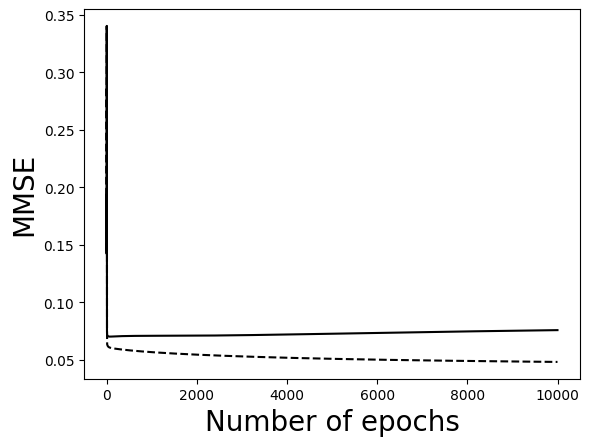

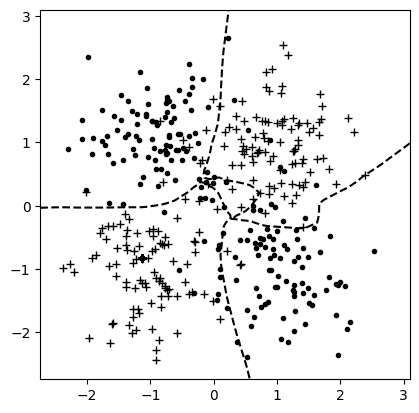

In [9]:
string="-"
for i in range(D.size):
    string=string+str(D[i])+"-"

plt.plot(range(epochs),np.reshape(E,epochs),'k--')
plt.plot(range(epochs),np.reshape(Etst,epochs),'k')
plt.xlabel("Number of epochs",fontsize=20)
plt.ylabel("MMSE",fontsize=20)
plt.show()



minx=np.ndarray.min(X)
maxx=np.ndarray.max(X)
x1=np.linspace(minx,maxx,100)
X1=np.tile(x1,(100,1))
X2=X1.T
xtst=np.array([X2.reshape(10000), X1.reshape(10000)]);
NN=forward(NN,xtst)
output=NN["h"][-1]
O=output.reshape(100,100);
#plt.imshow(O,extent=[minx, maxx, minx, maxx],cmap="Greys")
plt.plot(Xtst[0,indexp], Xtst[1,indexp], 'k.')
plt.plot(Xtst[0,indexn], Xtst[1,indexn], 'k+')
plt.contour(x1,x1,O,[0.5], colors="black",linestyles="dashed")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()